# LOH.1 benchmark with ExaHyPE 2

I assume that you've done the Euler example already, i.e. I can skip most of the basic stuff and go into medias res straightaway.

Compare to the Euler example, this is a more sophisticated example which uses an FV solver with nonconservative product. The example simulates elastic wave equations plus a diffuse interface model that takes material  interfaces into account.

Currently, we impose a Gaussian velocity pulse as initial solution but we will eventually simulate the LOH.1 benchmark.

We solve the governing equations using (a very diffusive) first-order FV solver. The code relies on snippets from the first version of ExaHyPE and from ExaSeis.

* Fore more details on the underlying mathematical modelling, see:
  https://www.sciencedirect.com/science/article/pii/S0021999119300786 

* For more details on the benchmark problem, see:
  http://sismowine.org/model/WP2_LOH1.pdf

* For more details on ExaSeis, see e.g.:
  https://mediatum.ub.tum.de/doc/1483700/1483700.pdf 


In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
project = exahype2.Project( 
  namespace    = ["examples", "exahype2", "loh1"], 
  project_name = "loh1", 
  directory    = "." )

Compared to the Euler equations, the big difference is that we use the ncp (non-conservative product). That is, we solve an equation with an additional term: 


$ \partial Q + \nabla ^T \cdot F(Q) + B(Q) \nabla Q = 0$

It might come as a surprise that we omit any conservative term (flux) here, but I explain this below:

In [3]:
mesh_size      = 10.0
time_step_size = 0.001


project.add_solver(  
  exahype2.solvers.fv.GenericRusanovFixedTimeStepSizeWithEnclaves(
    name           = "LOH1", 
    patch_size     = 5, 
    unknowns       = 3+6,      # vel(3) + stress(6)
    auxiliary_variables = 4,   #material parameters(3) + diffuse interface(1)  
    time_step_size = 0.01, 
    min_h          = mesh_size,
    max_h          = mesh_size,
    flux=exahype2.solvers.fv.PDETerms.None_Implementation,
    ncp=exahype2.solvers.fv.PDETerms.User_Defined_Implementation) )

While I personally always prefer to play around with Euler and 2d before I switch to Euler 3d, this time a 2d solve does not make any real sense. So we use 3d right from the start. The domain dimensions here are those from the standard benchmark.

In [4]:
dimensions=3 
project.set_global_simulation_parameters(
  dimensions            = dimensions,
  offset                = [0.0]*dimensions, 
  size                  = [30.0]*dimensions,
  #end_time              = 2.0,        
  end_time              = 0.1,
  first_plot_time_stamp = 0.0, 
  time_in_between_plots = time_step_size*10
)


The whole test is already relative compute-heavy, so we rely on parallelisation. The parameter clarifies that we want to work with an (MPI) domain decomposition that is 90% close to the optimum. The parameter allows us to balance between good domain decompositions and (very) long domain partitioning times.

In [5]:
project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision", "(0.9)" )

Finally, we generate the code. The actual implementation of the terms

$ \frac{\partial}{\partial t} \begin{pmatrix}
\sigma \\ \rho \ v
\end{pmatrix}
+
\nabla\cdot\begin{pmatrix}
{j}\\
\frac{1}{\rho}j\otimes j + p I \\
\frac{1}{\rho}j\,(E + p)
\end{pmatrix}
= 0
 $ 

and others can be found in the cpp files in the current directory. (this LaTeX formulation is yet to be finalised)

In [6]:
build_mode = peano4.output.CompileMode.Asserts
#build_mode = peano4.output.CompileMode.Release
#build_mode = peano4.output.CompileMode.Trace


project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated loh1-main.cpp
write ./Makefile
write ././AbstractLOH1.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.h)
write ././AbstractLOH1.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/LOH1Q.h (generated from template /home/tobias/git/Peano/p

In [7]:
parallel_builds = 8   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
In file included from LOH1.cpp:1:
LOH1.h:70:10: error: ‘void examples::exahype2::loh1::LOH1::nonconservativeProduct(const double*, const double (*)[3], const tarch::la::Vector<3, double>&, const tarch::la::Vector<3, double>&, double, int, double*)’ marked ‘override’, but does not override
   70 |     void nonconservativeProduct(
      |          ^~~~~~~~~~~~~~~~~~~~~~
In file included from ./observers/SolverRepository.h:21,
                 from facedata/LOH1Q.cpp:6:
./LOH1.h:70:10: error: ‘void examples::exahype2::loh1::LOH1::nonconservativeProduct(const double*, const double (*)[3], const tarch::la::Vector<3, double>&, const tarch::la::Vector<3, double>&, double, int, double*)’ marked ‘override’, but does not override
   70 |     void nonconservativeProduct(
      |          ^~~~~~~~~~~~~~~~~~~~~~
In file included from facedata/LOH1Q.cpp:6:
./observers/SolverRepository.h:26:16: error: cannot declare 

## Run benchmark

In [8]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
run of application was not successful: [Errno 2] No such file or directory: 'mpirun'
invocation: ['mpirun', '-n', '1', './peano4']


False

## Postprocessing of global runtimes

parse output.txt
file output.txt is invalid as number of time steps equals zero


/home/tobias/git/Peano/python/exahype2/postprocessing/overview_plots.py:22: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)


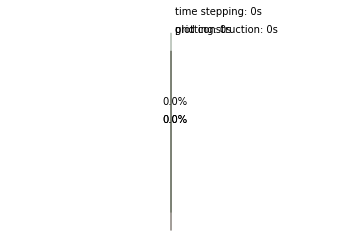

In [9]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

## Explicitly convert VTK files

In [10]:
import peano4.visualisation

peano_output_files = "solution-LOH1"
convert = peano4.visualisation.Convert( peano_output_files, True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()

ModuleNotFoundError: No module named 'paraview.simple'

The snippet above converts all data explicitly into VTU. This is likely not the most efficient way to study the outcome. See the guidebook how to open data directly within Paraview. In principle, you should be able to type in

import peano4.visualisation
visualiser = peano4.visualisation.Visualiser( "solution-LOH1.peano-patch-file" )
visualiser.display()
visualiser.append_filter(peano4.visualisation.ExtractFineGridFilter())
visualiser.write_vtu_time_series()
